# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

In [2]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

# Then import from noise_sampler_fixed_fc
from noise_sampler_fixed_fc import flicker_noise_sampler, flicker_likeli_func

Using the emulator for flicker noise correlation function.


In [3]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [4]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_1_indice
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0_list = [tod_sim.logf0]  # Convert to list format as expected later

In [5]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
Trec_prior_cov_inv = [aux] # Effectlively no prior


In [6]:
log_gain = np.log10(gain_proj@gain_params_setting)
# solve the linear system for the log_gain coeffs: gain_proj@ log_gain_coeffs = log_gain
log_gain_coeffs = np.linalg.lstsq(gain_proj, log_gain, rcond=None)[0]
print("log_gain_coeffs:", log_gain_coeffs)

gain_prior_cov_inv = np.zeros(4)
# prior_std_frac = 0.1
# gain_prior_cov_inv = 1. / (prior_std_frac * gain_params_setting)**2  # Prior STD ~100%
gain_prior_cov_inv[0] = 1/ (0.1 * 0.79977551)**2 # DC mode: Prior STD ~10%
gain_prior_mean = log_gain_coeffs

log_gain_coeffs: [0.79977551 0.02844282 0.01736516 0.00311427]


In [ ]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    log_linear_gain=True,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    #local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=3000,
                                    tol=1e-20,
                                    Est_mode=False)

# First, save the samples as npy files..

np.save("outputs/GS1/Tsys_samples_t2.npy", Tsys_samples)
np.save("outputs/GS1/gain_samples_t2.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1/noise_samples_t2.npy", np.concatenate(all_noise_samples, axis=0))



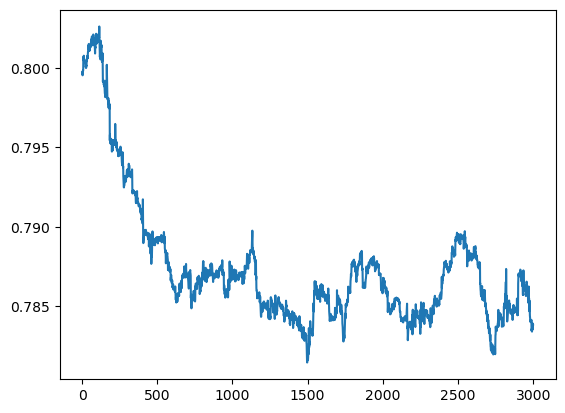

In [18]:
plt.plot(all_gain_samples[0][0,:,0])

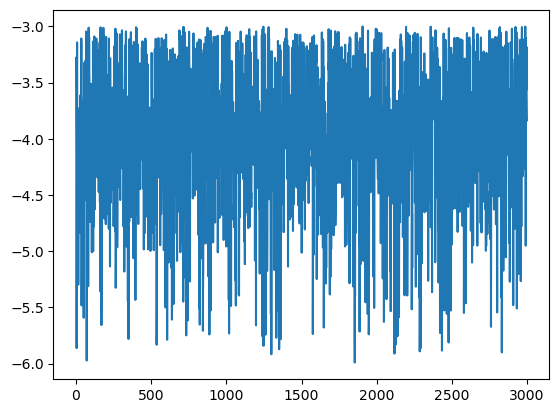

In [17]:
plt.plot(all_noise_samples[0][0,:,0])

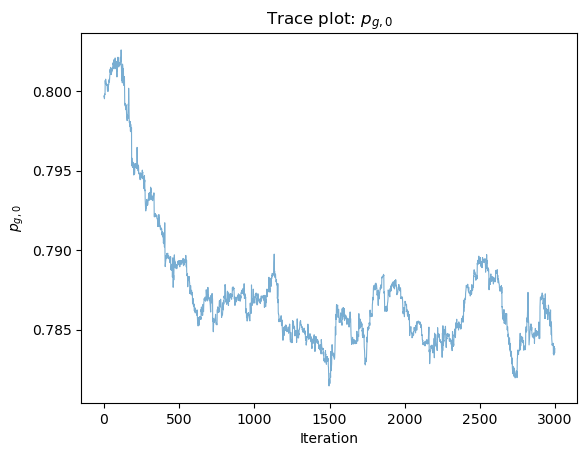

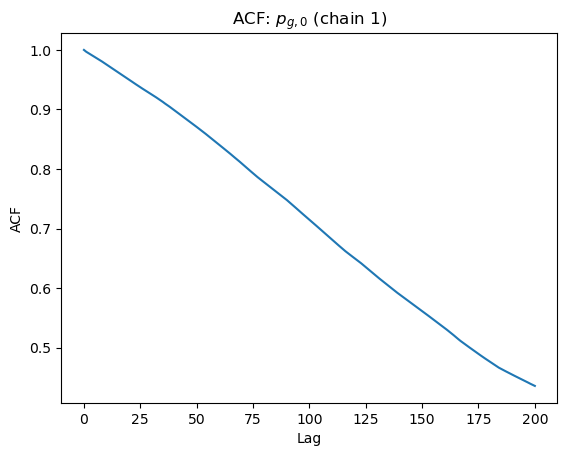

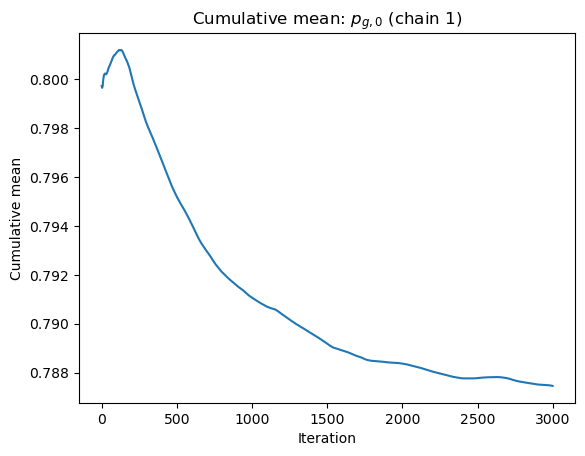

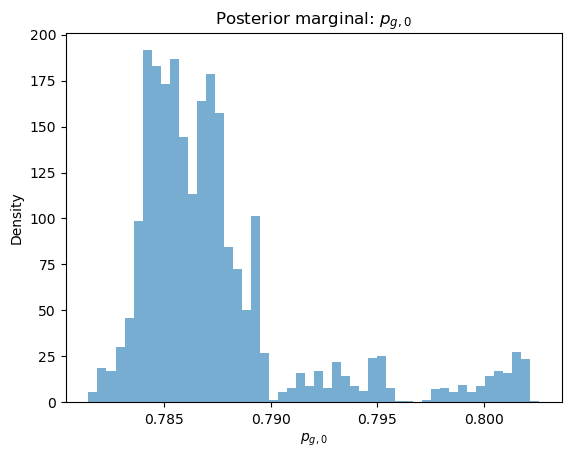

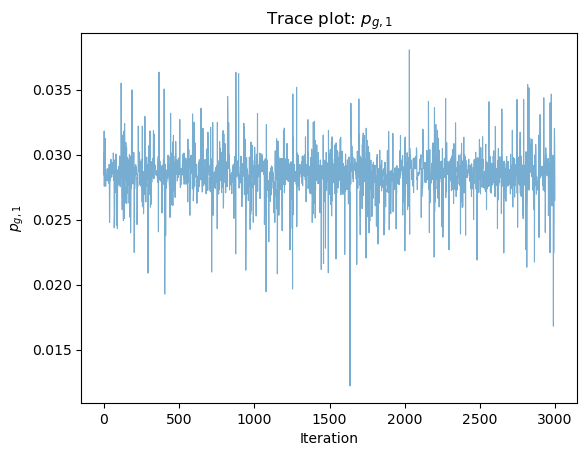

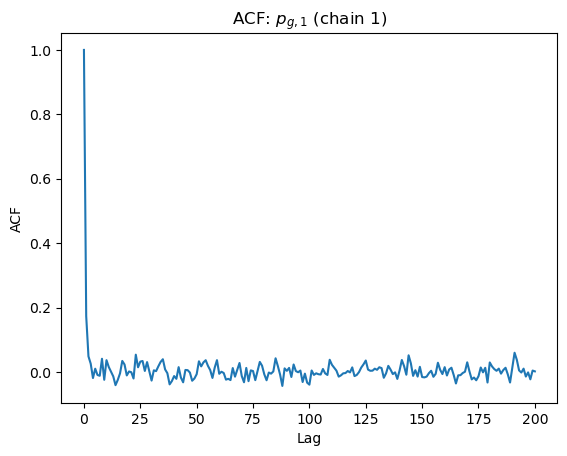

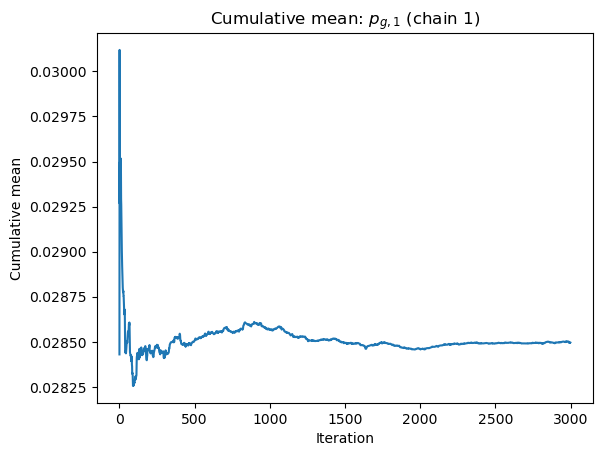

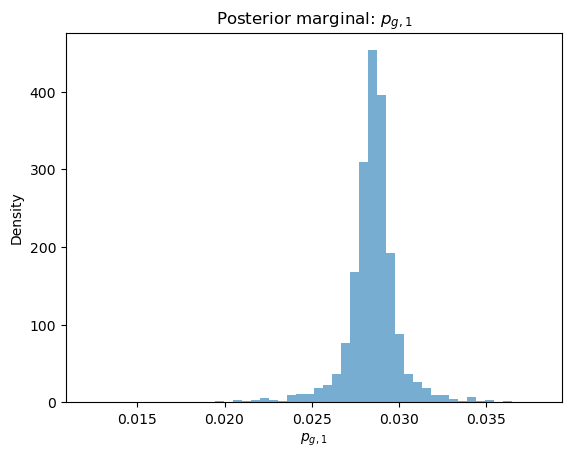

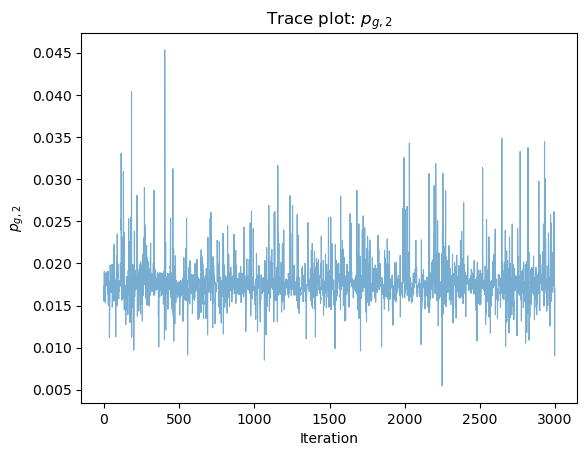

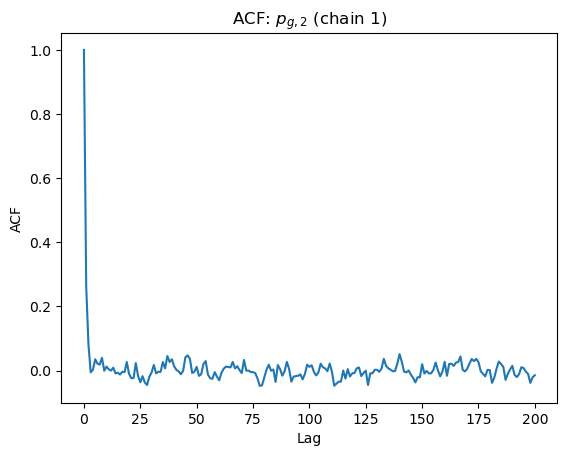

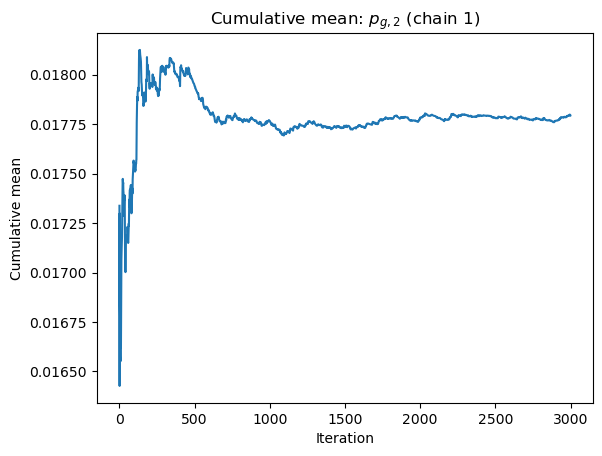

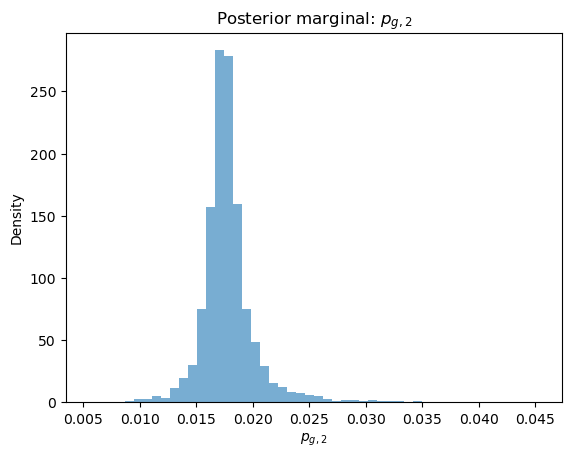

{'$p_{g,0}$': {'ESS_min': 6.440377268626616,
  'ESS_median': 6.440377268626616,
  'Rhat_split': 1.1856608638277002},
 '$p_{g,1}$': {'ESS_min': 2003.6958512062022,
  'ESS_median': 2003.6958512062022,
  'Rhat_split': 0.9996714400201924},
 '$p_{g,2}$': {'ESS_min': 1777.3157328724396,
  'ESS_median': 1777.3157328724396,
  'Rhat_split': 1.0001698452705834},
 '$p_{g,3}$': {'ESS_min': 1518.8682717885313,
  'ESS_median': 1518.8682717885313,
  'Rhat_split': 1.0007441133668225}}

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ========== Generic MCMC Diagnostics Toolkit ==========
# Input: samples as numpy array of shape (n_chains, n_draws, n_params)

def acf_1d(x, max_lag=200):
    x = np.asarray(x)
    x = x - x.mean()
    n = len(x)
    var = np.var(x, ddof=0)
    fft = np.fft.rfft(x, n=2*n)
    acf_full = np.fft.irfft(fft * np.conjugate(fft))[:n]
    acf_full = acf_full / (var * np.arange(n, 0, -1))
    return acf_full[:max_lag+1]

def ess_1d(x):
    x = np.asarray(x)
    x = x - x.mean()
    n = len(x)
    var = np.var(x, ddof=0)
    if var == 0:
        return n
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conjugate(fft))[:n]
    acf = acf / (var * np.arange(n, 0, -1))
    positive = acf[1:]
    pos_idx = np.argmax(positive <= 0.0)
    k = int(pos_idx) if (positive <= 0.0).any() else len(positive)
    s = 1 + 2 * np.sum(acf[1:1+k])
    return n / s if s > 0 else n

def rhat_split(chains_dim):
    m, n = chains_dim.shape
    if n % 2 == 1:
        chains_dim = chains_dim[:, :-1]
        n -= 1
    halves = np.reshape(chains_dim, (m*2, n//2))
    m2, n2 = halves.shape
    chain_means = halves.mean(axis=1)
    chain_vars = halves.var(axis=1, ddof=1)
    B = n2 * np.var(chain_means, ddof=1)
    W = np.mean(chain_vars)
    var_hat = (n2 - 1)/n2 * W + B/n2
    Rhat = np.sqrt(var_hat / W)
    return float(Rhat)

def diagnostics(samples, param_names=None, max_plots=3):
    n_chains, n_draws, n_params = samples.shape
    if param_names is None:
        param_names = [f"param{i}" for i in range(n_params)]
    
    summary = {}
    for d, name in enumerate(param_names):
        ess_list = [ess_1d(samples[c, :, d]) for c in range(n_chains)]
        summary[name] = {
            "ESS_min": float(np.min(ess_list)),
            "ESS_median": float(np.median(ess_list)),
            "Rhat_split": rhat_split(samples[:, :, d])
        }
    
    # --- Plot some quick diagnostics for first few parameters ---
    for d in range(min(n_params, max_plots)):
        name = param_names[d]
        
        # Trace
        plt.figure()
        for c in range(n_chains):
            plt.plot(samples[c, :, d], alpha=0.6, lw=0.8)
        plt.title(f"Trace plot: {name}")
        plt.xlabel("Iteration")
        plt.ylabel(name)
        plt.show()
        
        # ACF (first chain)
        acf_vals = acf_1d(samples[0, :, d])
        plt.figure()
        plt.plot(acf_vals)
        plt.title(f"ACF: {name} (chain 1)")
        plt.xlabel("Lag")
        plt.ylabel("ACF")
        plt.show()
        
        # Cumulative mean (first chain)
        cum_mean = np.cumsum(samples[0, :, d]) / np.arange(1, n_draws+1)
        plt.figure()
        plt.plot(cum_mean)
        plt.title(f"Cumulative mean: {name} (chain 1)")
        plt.xlabel("Iteration")
        plt.ylabel("Cumulative mean")
        plt.show()
        
        # Histogram
        flat = samples[:, :, d].reshape(-1)
        plt.figure()
        plt.hist(flat, bins=50, density=True, alpha=0.6)
        plt.title(f"Posterior marginal: {name}")
        plt.xlabel(name)
        plt.ylabel("Density")
        plt.show()
    
    return summary

# ========== Demo: Reuse previous Gibbs chains (2D Gaussian) ==========
summary_demo = diagnostics(all_gain_samples[0], param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"])
summary_demo

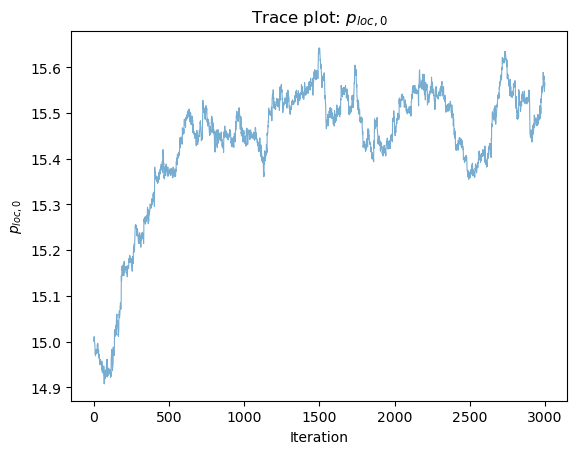

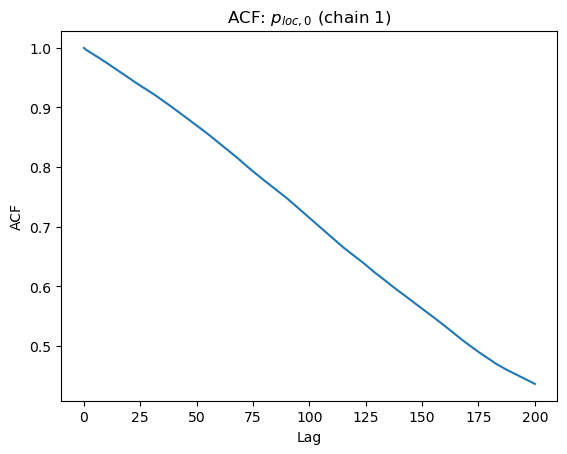

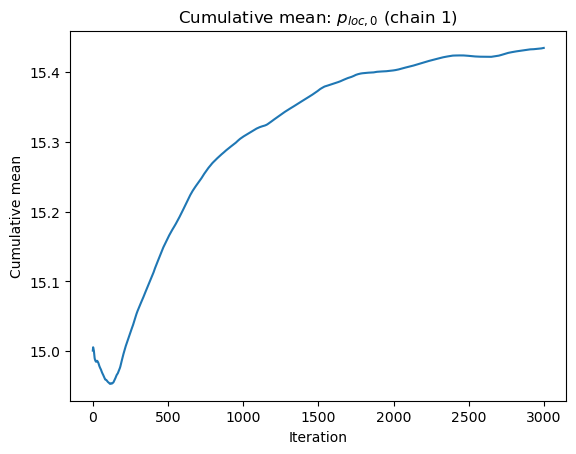

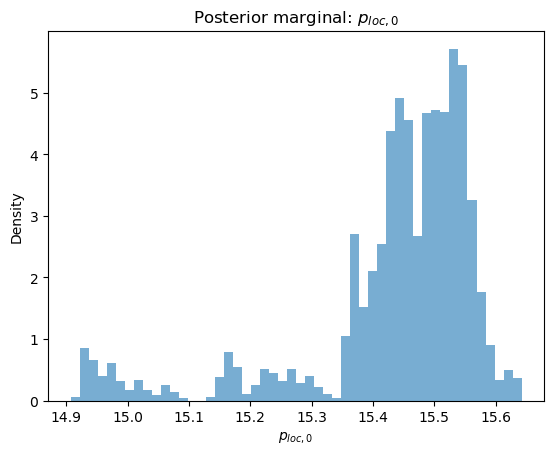

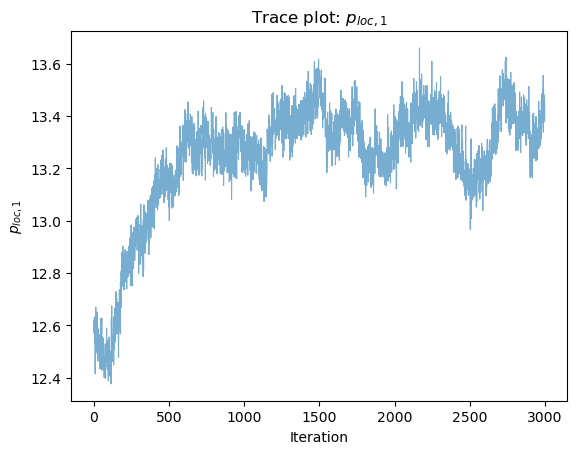

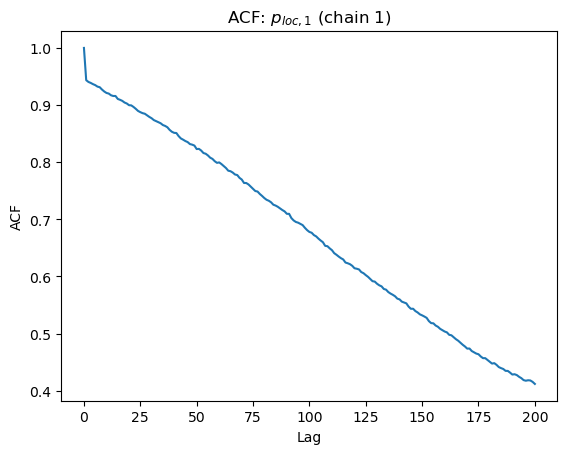

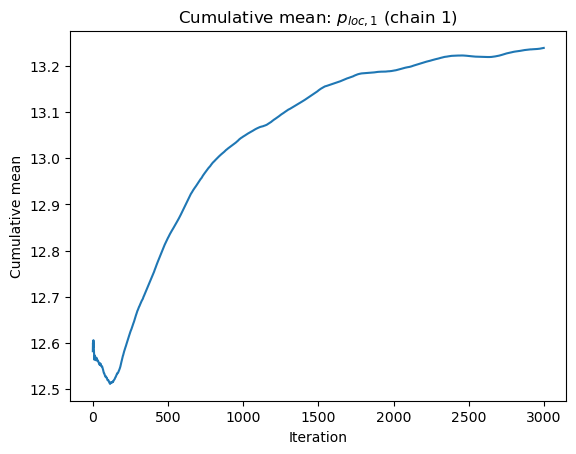

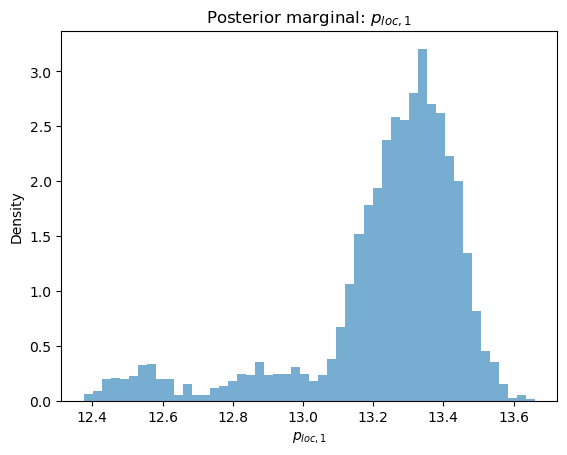

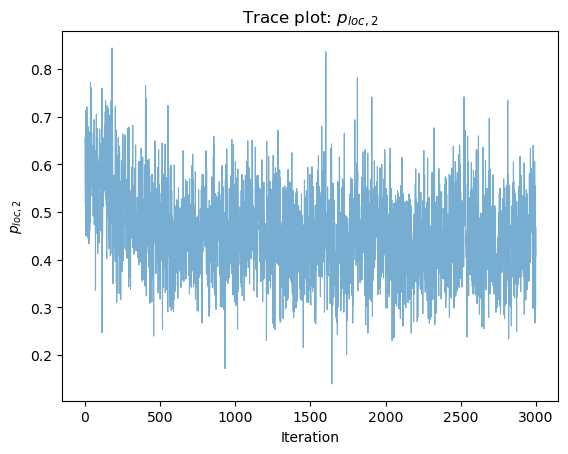

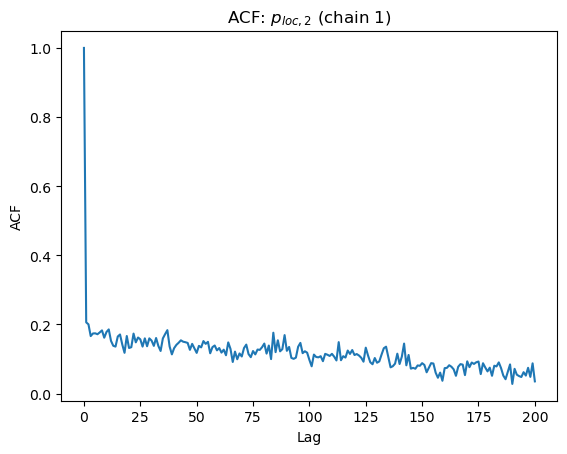

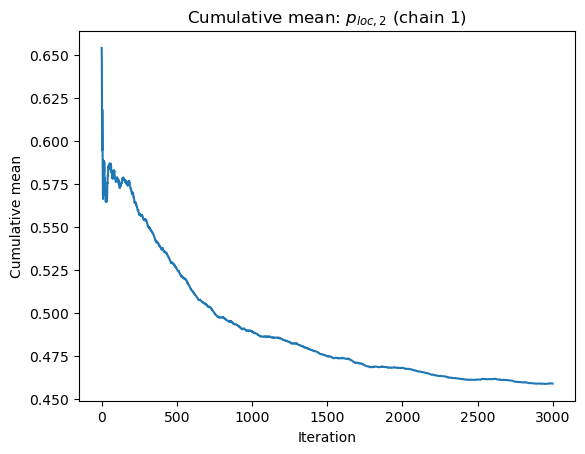

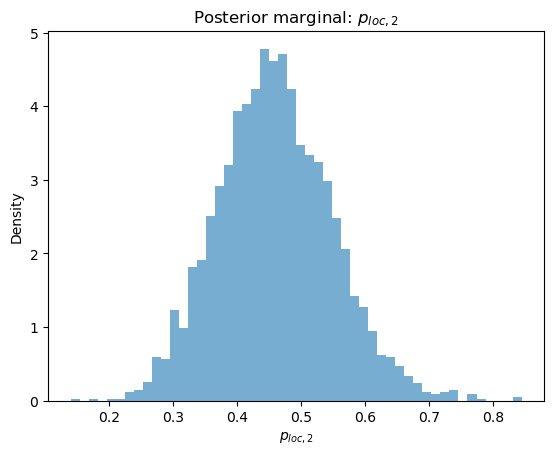

{'$p_{loc,0}$': {'ESS_min': 6.402093883815493,
  'ESS_median': 6.402093883815493,
  'Rhat_split': 1.1874702985368084},
 '$p_{loc,1}$': {'ESS_min': 6.780111431248319,
  'ESS_median': 6.780111431248319,
  'Rhat_split': 1.1767293983749516},
 '$p_{loc,2}$': {'ESS_min': 49.75814987004664,
  'ESS_median': 49.75814987004664,
  'Rhat_split': 1.0325792734958756},
 '$p_{loc,3}$': {'ESS_min': 222.56920433513596,
  'ESS_median': 222.56920433513596,
  'Rhat_split': 1.007884881438244},
 '$p_{loc,4}$': {'ESS_min': 2335.4972391912584,
  'ESS_median': 2335.4972391912584,
  'Rhat_split': 1.0002119422002536}}

In [25]:
# ========== Demo: Reuse previous Gibbs chains (2D Gaussian) ==========
summary_demo = diagnostics(Tsys_samples[:, -5:].reshape(1, -1, 5), param_names=[r"$p_{loc,0}$", r"$p_{loc,1}$",r"$p_{loc,2}$",r"$p_{loc,3}$",r"$p_{loc,4}$"])
summary_demo

(3000, 380)

In [24]:
sky_params.shape

(375,)